In [172]:
import numpy as np
import pandas as pd
from typing import Tuple, List
import matplotlib.pyplot as plt

## Data reading

In [173]:
# incarcarea datelor

# data source: http://archive.ics.uci.edu/ml/datasets/Condition+Based+Maintenance+of+Naval+Propulsion+Plants
file = 'data.txt'
data_df = pd.read_csv(file, sep=r'\s+', header=None)
data = data_df.values

In [174]:
# se sterge penultima coloana

data = np.delete(data, -2, axis=1)
print(data.shape)
assert data.shape == (11934, 17)

(11934, 17)


## Input processing

In [175]:
# Functie pentru separarea datelor de intrare de cele de iesire

def get_input_output(mat: np.array) -> Tuple[np.array, np.array]:
    """Separa partea de intrare (variabile independente) de cea de iesire 
    (variabila dependenta).
    
    :param mat: np.array de forma (m, n). Fiecare linie este un caz 
    inregistrat, adica un vector de intrare. Primele n-1 coloane sunt valori 
    de intrare in model, ultima coloana este valoarea de iesire asociata 
    (ground truth).
    
    :return: un tuplu cu: matrice de (m, n-1) continand intrarile 
    (o linie = un vector de intrare); un vector coloana cu m linii continand
    valorile de iesire asociate intrarilor.
    """
    m, n = mat.shape
    X = mat[:, :-1]
    y = mat[:, -1].reshape(-1,1)
    assert np.alltrue(X == mat[:, :-1])
    assert np.alltrue(y[:, -1] == mat[:, -1])
    return X, y

In [176]:
# separa matricea cu vectorii de intrare si vectorul coloana cu iesirile asociate

X, y =get_input_output(data)

In [177]:
# Functie pentru scalarea datelor in intervalul [0, 1]. 
# Scalele se calculeaza pe baza datelor furnizate

def scale_matrix(mat: np.array) -> np.array:
    """Preia o matrice cu valori reale si scaleaza toate coloanele in 
    intervalul [0, 1]. Coloanele constante vor fi transformate in 1.
    
    :param mat: matrice de forma (m, n)
    :return: matrice cu valori scalate in [0, 1]
    """
    
    # calculeaza pe ce indecsi minimele si maximele difera. 
    # Doar pe acestea se va face scalare. Coloanele pentru care minimele si 
    # maximele sunt egale au valori constante si vor fi umplute automat cu 1.
    min_cols, max_cols = mat.min(0),mat.max(0)
    # de pe fiecare coloana a lui mat
    different_min_max = mat.min(0)!=mat.max(0)
    # minimele si maximele difera
    result = np.ones_like(mat)
    result[:, different_min_max] = ((mat[:, different_min_max]-min_cols[different_min_max])/(max_cols[different_min_max]-min_cols[different_min_max]))
    assert result.shape == mat.shape
    assert np.alltrue(np.min(result, axis=0) >= 0)
    assert np.alltrue(np.max(result, axis=0) <= 1)
    return result, min_cols, max_cols

In [178]:
# Functie pentru scalarea datelor. 
# Scalele sunt furnizate, de regula calculate pe baza datelor din setul 
# de antrenare

def scale_matrix_with_known_minmax(mat: np.array, min_cols: np.array, max_cols: np.array) -> np.array:
    """Preia o matrice  :param mat: si efectueaza scalarea valorilor in 
    intervalul [0, 1] folosind valori de min si max pe fiecare coloana 
    precalculate si date prin parametrii :param min_cols:, :param max_cols:.
    
    :param mat: matricea de (m, n) care trebuie scalata.
    :param min_cols: minime pe coloane, precalculate
    :param max_cols: maxime pe coloane, precalculate
    :return: matrice de (m, n) cu valori scalate.
    """
    # calculeaza pe ce indecsi minimele si maximele difera. 
    # Doar pe acestea se va face scalare. Coloanele pentru care minimele si 
    # maximele sunt egale au valori constante si vor fi umplute automat cu 1.
    different_min_max = mat.min(0)!=mat.max(0)
    # scrieti cod pentru a determina pe ce coloane difera 
    # minimele si maximele (coloane cu valori necosntante)
    result = np.ones_like(mat)
    result[:, different_min_max] = ((mat[:, different_min_max]-min_cols[different_min_max])/(max_cols[different_min_max]-min_cols[different_min_max]))
    # scrieti cod care sa scaleze datele 
    # folosind parametrii min_cols si max_cols dati
    assert result.shape == mat.shape
    return result

In [179]:
# scaleaza matricele

X, min_cols, max_cols = scale_matrix(X)
# scrieti cod pentru a scala X intre 0 si 1 # aici min_cols si max_cols nu vor fi de fapt folosite
y, _, _ = scale_matrix(y)
# scrieti cod pentru a scala coloana y in [0, 1]

In [180]:
# calculeaza matricea de design: coloana de 1 adaugata in fata datelor originare

def design_matrix(mat: np.array) -> np.array:
    """Preia o matrice de forma (m, n) si returneaza o matrice de forma 
    (m, n+1), in care prima coloana este 1, iar ultimele n coloane sunt 
    coloanele lui :param mat:.
    
    :param mat: matrice de forma (m, n)
    :return: matrice de forma (m, n+1), cu prima coloana plina cu 1, ultimele 
    n coloane sunt cele din :param mat:
    """
    m, n = mat.shape
    result = np.insert(mat,0,1,axis=1)
    assert result.shape == (m, n+1)
    assert np.alltrue(result[:, 0] == 1)
    assert np.alltrue(result[:, 1:] == mat)
    return result

In [181]:
# calculeaza matricea de design: vechea matrice la care se adauga pe prima
# pozitie coloana cu 1
X =design_matrix(X)

## Linear regression with stochastic gradient descent

### Model implementation

In [182]:
# Functie care implementeaza modelul de regresie liniara

def h(X: np.array, w: np.array) -> np.array:
    """Pentru un model liniar specificat prin parametrii w si un set de date 
    de intrare X produce valorile estimate de model: 
    y_hat[i] = X[i, 0] * w[0] + X[i, 1] * w[1] + ...  
   
   :param X: valori de intrare, structurate ca np.array de forma (m, n)
   :param w: vector de ponderi, de forma (n, 1)
   :return: vector cu valori de iesire estimate, de forma (n, 1). 
    """
    assert w.shape == (X.shape[1], 1)
    assert X.shape[1] == w.shape[0]
    y_hat = np.dot(X,w)
    assert y_hat.shape == (X.shape[0], 1)
    return y_hat

### MSE function

In [183]:
# Implementare de eroare patratica medie

def mean_squared_error(y: np.array, y_hat: np.array) -> float:
    """Functie de eroare patratica medie.
    
    :param y: vector coloana de m elemente, continand valorile de iesire reale 
    (ground truth)
    :param y_hat': vector coloana de m elemente, continand valorile de iesire
    estimate.
    :return: eroarea patratica medie.
    """
    result=((y-y_hat)**2).sum()/np.shape(y)[0]
    return result

### Cost function

In [184]:
# Functia de eroare

def J(X:np.array, w:np.array, y:np.array, lmbda: float = 0) -> float:
    """Calculeaza valoarea functiei de eroare pentru intrarea curenta :param X:, 
    estimarea produsa de model folosind ponderile :param w: si iesirea corecta
    :param y: (ground truth).
    
    :param X: matrice de valori de intrare pentru care modelul de regresie 
    liniara produce estimari. Are forma (m, n)
    :param w: vector coloana de ponderi, definind coeficientii modelului de 
    regresie liniara. Are forma (n, 1).
    :param y: vector coloana de valori de iesire cunoscute (ground truth). 
    Are forma (n, 1).
    :param lmda: coeficientul de penalizare L2
    :return: jumatate din mean squared error plus penalizarea L2
    """
    assert w.shape == (X.shape[1], 1)
    assert y.shape == (X.shape[0], 1)
    assert lmbda >= 0
    m = X.shape[0]
    y_hat = h(X,w)
    assert y_hat.shape == (X.shape[0], 1)
    term_squared_error = mean_squared_error(y,y_hat)/2
    l2_error = (w*w).sum()*lmbda
    return term_squared_error + l2_error 

### Stochastic gradient descent implementation

In [185]:
# Calcul de gradient. gradientul se va folosi in actualizarea ponderilor. 

def gradient(X:np.array, w:np.array, y:np.array, lmbda: float = 0) -> np.array:
    """Calculeaza gradientul functiei de eroare
    
    :param X: matrice de valori de intrare pentru care modelul de regresie 
    liniara produce estimari. Are forma (m, n)
    :param w: vector coloana de ponderi, definind coeficientii modelului de 
    regresie liniara. Are forma (n, 1).
    :param y: vector coloana de valori de iesire cunoscute (ground truth). 
    Are forma (n, 1).
    :param lmda: coeficientul de penalizare L2
    :return: vector gradient
    """
    assert w.shape == (X.shape[1], 1)
    assert y.shape == (X.shape[0], 1)
    assert lmbda >= 0
    m, _ = X.shape
    y_hat = h(X,w)
    grad = (np.dot(np.transpose((y_hat-y)),X))/X.shape[0]
    grad[1:, ] += np.transpose(lmbda*w)[1:,]
    grad=np.transpose(grad)
    assert grad.shape == w.shape
    return grad

In [186]:
# Implementarea algoritmului de antrenare

def train(X:np.array, y:np.array, max_iters:int = 100000, alpha:float = 0.01, lmbda: float = 0.01) -> Tuple[np.array, List[float]]:
    """Aplica algoritmul de instruire cu gradient. 
    
    :param X: matrice de valori de intrare pentru care modelul de regresie 
    liniara produce estimari. Are forma (m, n)
    :param y: vector coloana de valori de iesire cunoscute (ground truth). 
    Are forma (n, 1).
    :param alpha: rata de invatare
    :param lmda: coeficientul de penalizare L2
    :return: tuplu continand ponderile modelului rezultate dupa instruire, lista de erori pe setul de antrenare
    """
    m, n = X.shape
    assert y.shape == (m, 1)
    assert X.shape[0] == y.shape[0]
    w = np.zeros((n,1),dtype=type(X[0][0]))
    losses = [None] * max_iters
    for i in range(max_iters):
        # calculeaza si adauga loss-ul in lista 
        # calculeaza gradientul si actualizaeaza ponderile w
        loss =  J(X,w,y,lmbda)
        losses[i] = loss
        grad = gradient(X,w,y,lmbda)
        w -= alpha*grad
    return w, losses

In [187]:
# calcul ponderi si valorile functiei de cost

w, losses = train(X, y, max_iters=100000, alpha=0.3, lmbda=0.1)
print(losses)

[0.16999999999999998, 0.13018521081968865, 0.08940358111101432, 0.07926318912717029, 0.06321004249705445, 0.061806830499776866, 0.05513182061875782, 0.05587967927360169, 0.05293156655806143, 0.05391716855844082, 0.052535859716149984, 0.053306577734344426, 0.05262531024985269, 0.05314654714168178, 0.05279696453261315, 0.05312846226972388, 0.05294419480058812, 0.05314894939387582, 0.053050418360978166, 0.053175257544855206, 0.053122518000370184, 0.053198463520904564, 0.05317071821025367, 0.05321728382179514, 0.053203427057799575, 0.053232570386763205, 0.05322657583350436, 0.05324552324602891, 0.05324409103530462, 0.053257177410863436, 0.05325849332285466, 0.05326830907919586, 0.05327137523994722, 0.05327946552766425, 0.0532837342466639, 0.05329102005203876, 0.05329619191495426, 0.05330322205545575, 0.053309134209372076, 0.05331623564816034, 0.053322799980936315, 0.05333016736932869, 0.05333733638001158, 0.0533450853874633, 0.053352833428645406, 0.053361032521381954, 0.05336934555716876, 

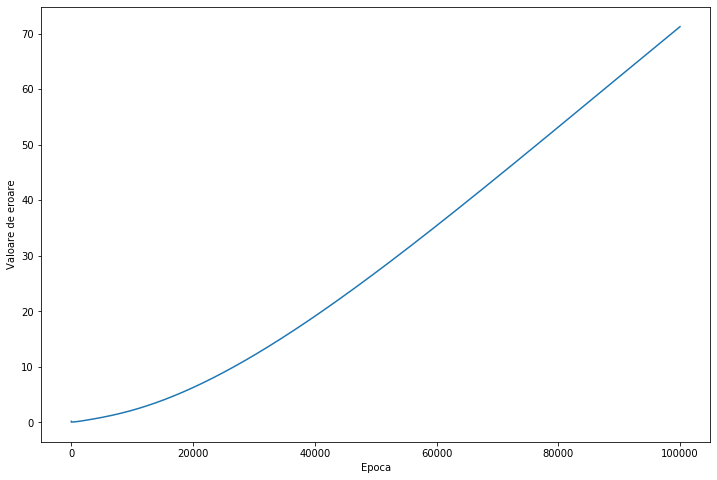

In [188]:
# desenarea curbei de cost pe setul de antrenare

plt.figure(figsize=(12, 8))
plt.xlabel('Epoca')
plt.ylabel('Valoare de eroare')
plt.plot(losses)

In [189]:
# Obtine valorile estimate de model, calculeaza eroarea intre estimare si 
# ground truth.

# estimare facuta de model
y_hat = h(X,w)
# mean squared error pe setul de antrenare
error_sgd = mean_squared_error(y,y_hat)

print('Eroarea determinata prin algoritmul stochastic gradient descent:', error_sgd)
print('Vectorul de ponderi:', w[:, 0])

Eroarea determinata prin algoritmul stochastic gradient descent: 0.03071144349906421
Vectorul de ponderi: [  0.22198621   0.48849496   0.31456382  12.72594301   3.15185209
   1.37715717  -3.52915283  -3.52915283  -1.48893964   0.22198621
   0.85916279   4.31774743   0.22198621 -21.52389306   5.21130965
   0.16230677   1.01103246]


### Pseudoinverse method

In [190]:
# se calculeaza w cu metoda pseudoinversei 
w_pinv = np.dot(np.linalg.pinv(X),y)

# se calculeaza estimarea data cu ponderile w_pinv
y_hat_pinv = h(X,w_pinv)

# se calculeaza eroarea patratica medie
error_pinv= mean_squared_error(y,y_hat_pinv)

print('Eroarea determinata prin metoda pseudoinversei:', error_pinv)

Eroarea determinata prin metoda pseudoinversei: 0.008010137201200604


In [191]:
print(np.linalg.norm(gradient(X, w_pinv, y)))

6.147904784172323e-15


In [192]:
# afiseaza ponderile determinate prin metoda pseudoinversei

print(w_pinv[:, 0])

[  0.29015495   0.39839967   5.56767682  40.06318117   5.89697855
   4.03988449 -20.25484653 -20.25484653 -18.34254684   0.29015495
   1.81835155  11.32697686   0.29015495 -37.23147039   1.22929938
  -0.88382777  25.32182337]


## Split validation

In [193]:
# imparte setul initial in 70% antrenare si 30% testare

data =np.random.permutation(data)
split_percentage = 0.7
split_index = int(data.shape[0]*split_percentage)
data_train = data[0:split_index+1][:]
data_test = data[split_index+1:][:]

X_train, y_train = get_input_output(data_train)
X_test, y_test = get_input_output(data_test)

In [194]:
# scaleaza datele de intrare din setul de antrenare si obtine minimele 
# si maximele pe coloane
X_train, min_X_train, max_X_train = scale_matrix(X_train)
# scaleaza datele de iesire din setul de antrenare si obtine minimul si 
# maximul pe coloana
y_train, min_y_train, max_y_train =scale_matrix(y_train)

In [195]:
# scaleaza datele de intrare din setul de test, folosind minimele si maximele 
# pe coloane aflate de la X_train
# se foloseste functia scale_matrix_with_known_minmax
X_test = scale_matrix_with_known_minmax(X_test,min_X_train,max_X_train) 

# scaleaza datele de iesire din setul de test, folosind minimul si maximul 
# pe coloana aflate de la y_train
y_test = scale_matrix_with_known_minmax(y_test,min_y_train,max_y_train) 

In [196]:
# antreneaza linear regression pe setul de antrenare, obtine ponderile
# modelului

w_train, losses_train =  train(X_train, y_train, max_iters=10000, alpha=0.1, lmbda=0.1)
# restul parametrilor ca la apelul de antrenare de mai sus

In [197]:
# obtine estimarile date de model pe setul de testare

y_hat_test = h(X_test,w_train)
print('MSE pentru setul de testare:', mean_squared_error(y_test, y_hat_test))

MSE pentru setul de testare: 0.0785366690604066


Text(0, 0.5, 'Diferenta intre ground truth si valoarea estimata')

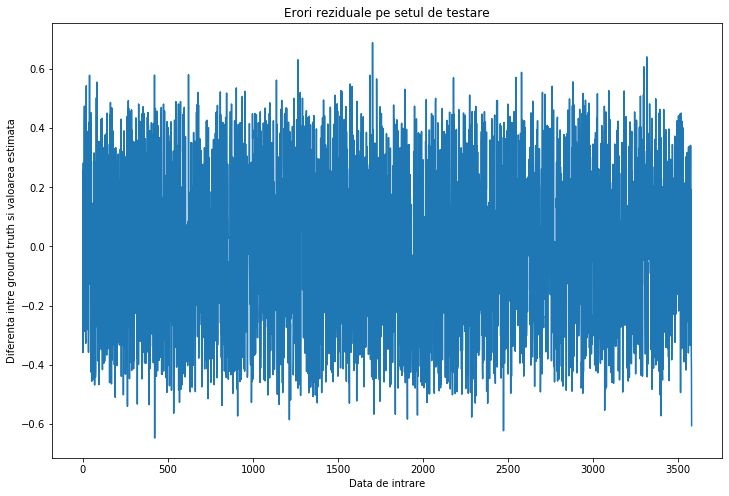

In [198]:
# reprezentarea diferentei intre ground truth si estimare pe setul de testare
plt.figure(figsize=(12, 8))
plt.title('Erori reziduale pe setul de testare')
plt.plot(y_test - y_hat_test)
plt.xlabel('Data de intrare')
plt.ylabel('Diferenta intre ground truth si valoarea estimata')